# Full Train/Test

In [1]:
import audiomod
import ptmod

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from pymongo import MongoClient

# from functools import partial

import matplotlib.pyplot as plt
# import seaborn as sns
# plt.style.use('seaborn')

from copy import deepcopy
import pickle
import os

%matplotlib inline

In [3]:
client = MongoClient(
    "mongodb://{}:{}@{}/kojak".format(
        os.environ['mdbUN'],
        os.environ['mdbPW'],
        os.environ['mdbIP']
    )
)

kdb = client.kojak

## Creating test datagroup in  MongoDB 

Using freshly-labeled samples...

In [6]:
# kdb.test_songs.find({"sax": 2, "sax1203": {"$exists": False}}).count()

83

In [7]:
# res = kdb.test_songs.update_many(
#     {"sax": 2, "sax1203": {"$exists": False}},
#     {"$set": {"sax1206_test": 1}}
# )
# res.modified_count

83

In [22]:
# no_sax = kdb.test_songs.aggregate([
#             {"$match": {"sax": 0, "sax1203": {"$exists": False}}},
#             {"$sample": {"size": 83}}
#         ]) 

In [23]:
# for entry in no_sax:
#     chunk_id = entry['chunk_id']
#     result = kdb.test_songs.update_one(
#         {"chunk_id": chunk_id},
#         {"$set": {"sax1206_test": 0}}
#     )
#     if result.modified_count != 1:
#         print("shit!")

In [24]:
# kdb.test_songs.find({"sax1206_test": {"$exists": True}}).count()

166

## Train/Test

In [4]:
sax1203 = audiomod.pull_datagroup_from_db('sax1203')
sax1206_test = audiomod.pull_datagroup_from_db('sax1206_test')
print(len(sax1203))
print(len(sax1206_test))

920
166


In [5]:
train_ds = ptmod.SpectroDataset(sax1203, scaling=0.25)
test_ds = ptmod.SpectroDataset(sax1206_test, scaling=0.25)

In [6]:
params = {
    'c1': [5,2,10],
    'p1': [2,2],
    'c2': [5,2,20],
    'p2': [2,2],
    'f1': [700,100],
    'f2': [100,2]
}

In [7]:
cnn = ptmod.CNN_cpcpff(params, rs=42)

In [8]:
loss_by_epoch = ptmod.fit(
    cnn,
    train_ds,
    optim.Adam(cnn.parameters(), lr=0.0002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01),
    nn.CrossEntropyLoss(),
    12,
    16
)

Epoch 1
 * Avg loss: 0.657	Time: 9950.125 ms
 * Weights updated: True
Epoch 2
 * Avg loss: 0.605	Time: 10637.990 ms
 * Weights updated: True
Epoch 3
 * Avg loss: 0.551	Time: 10205.750 ms
 * Weights updated: True
Epoch 4
 * Avg loss: 0.521	Time: 10506.965 ms
 * Weights updated: True
Epoch 5
 * Avg loss: 0.483	Time: 10708.921 ms
 * Weights updated: True
Epoch 6
 * Avg loss: 0.449	Time: 10900.970 ms
 * Weights updated: True
Epoch 7
 * Avg loss: 0.430	Time: 11999.921 ms
 * Weights updated: True
Epoch 8
 * Avg loss: 0.413	Time: 10889.640 ms
 * Weights updated: True
Epoch 9
 * Avg loss: 0.401	Time: 11021.130 ms
 * Weights updated: True
Epoch 10
 * Avg loss: 0.400	Time: 10876.009 ms
 * Weights updated: True
Epoch 11
 * Avg loss: 0.421	Time: 11069.242 ms
 * Weights updated: True
Epoch 12
 * Avg loss: 0.384	Time: 11004.233 ms
 * Weights updated: True

Training Complete


In [9]:
train_predict = ptmod.predict(cnn, train_ds)
test_predict = ptmod.predict(cnn, test_ds)

## Results

In [10]:
scores = ptmod.get_scores(train_predict, test_predict)
ptmod.print_scores(scores)

Score	Train	Test
------------------------
Acc	0.836	0.771
Rec	0.833	0.807
Spec	0.839	0.735


In [11]:
# results_model_1206 = {
#     "train": train_predict,
#     "test": test_predict,
#     "scores": scores,
#     "losses": loss_by_epoch
# }
# with open("../data/results_model_1206.p", 'wb') as pf:
#     pickle.dump(results_model_1206, pf)

In [2]:
with open("../data/results_model_1206.p", 'rb') as pf:
    results = pickle.load(pf)

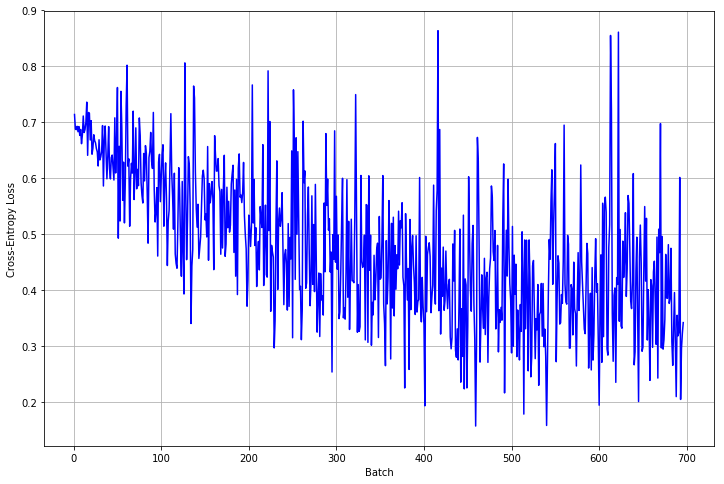

In [15]:
ptmod.plot_loss(
    loss_by_epoch, 
    model_name=None, 
    plot_values='all',
    save=True,
    fname='loss_per_batch_1206'
)

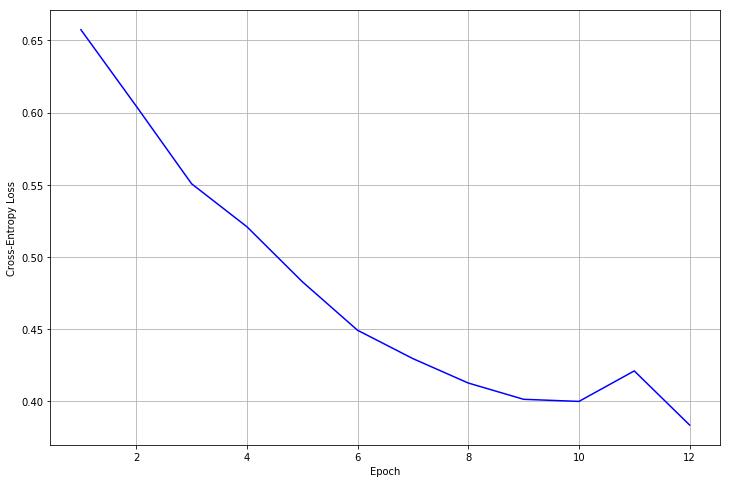

In [16]:
ptmod.plot_loss(
    loss_by_epoch, 
    model_name=None, 
    plot_values='epoch',
    save=True,
    fname='loss_per_epoch_1206'
)

Combine these two for Friday!

In [3]:
test_predict = results['test']

In [4]:
test_predict[(test_predict.actual == test_predict.pred) &
             (test_predict.actual == 1)
            ]

,chunk_id,actual,pred,e0,e1
1,000733,1,1,0.928661,2.803630
2,000750,1,1,0.000000,3.297669
3,000878,1,1,0.918470,2.119547
7,001254,1,1,1.266838,1.905834
12,001514,1,1,1.246408,1.511342
13,001542,1,1,0.000000,3.307677
14,001579,1,1,0.538088,2.346641
18,001839,1,1,1.322207,1.655431
19,001852,1,1,1.460638,1.788057
20,001949,1,1,1.277417,1.526330
